# Importations

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv("data/ai4i2020.csv")
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [67]:
drop_columns = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
utils_columns = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]"]

# Pre-processing

### TrainTest - Nettoyage - Encodage

In [68]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [69]:
trainset["Machine failure"].value_counts()

Machine failure
0    7736
1     264
Name: count, dtype: int64

In [70]:
testset["Machine failure"].value_counts()

Machine failure
0    1925
1      75
Name: count, dtype: int64

### Features Engineering

In [71]:
def features_engineering(df):
    df['power_machine'] = df['Torque [Nm]'] * (  3.14 * df['Rotational speed [rpm]'] / 30 )
    df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
    return df

In [72]:
def imputation(df):
    df = df.drop(columns=drop_columns + utils_columns, axis=1)
    return df

In [ ]:
def preprocessing(df):
    df = features_engineering(df)
    df = imputation(df)

    X, y = df.drop("Machine failure", axis=1264/7736),  df["Machine failure"]
    print(y.value_counts())
    
    return X, y
    

In [74]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

Machine failure
0    7736
1     264
Name: count, dtype: int64
Machine failure
0    1925
1      75
Name: count, dtype: int64


# Modelisation

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest

In [78]:
type_order = ["L", "M", "H"]

In [80]:
column_transformer = ColumnTransformer(transformers=[
    ("type_encoder", OrdinalEncoder(categories=[type_order], handle_unknown="use_encoded_value", unknown_value=-1), ["Type"])
], remainder="passthrough")

In [83]:
preprocessor = make_pipeline(
    column_transformer,
    SelectKBest(k="all"),
)

In [ ]:
RandomForest = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("rf", RandomForestClassifier(random_state=0, n_jobs=6))
    ])

DecisionTreeC = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("decisionTreeClassifier", DecisionTreeClassifier(random_state=0))
    ])
AdaBoost = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("AdaBoost", AdaBoostClassifier(random_state=0))
    ])
KNNe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("scaler", StandardScaler()),
    ("KNNe", KNeighborsClassifier())
    ])
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("xgb", XGBClassifier(random_state=0, n_jobs=6))
    ])

In [90]:
dict_of_models = {'rf' : RandomForest, 
                  'decisionTreeClassifier' : DecisionTreeC,
                  'xgb' : xgb_pipe,
                  'AdaBoost' : AdaBoost,
                  'KNNe' : KNNe
                  }

# Evaluation

In [96]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


In [97]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1 ,1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

In [98]:
def get_feature_importances(pipeline, step_preprocessor, step_model_name):
    step_model_name = pipeline.named_steps[step_model_name]
    feature_names = pipeline.named_steps[step_preprocessor].get_feature_names_out()
    # Récupérer les importances
    importances = step_model_name.feature_importances_
    # Mettre dans un DataFrame et tracer
    pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values(by="importance", ascending=False).plot.bar(figsize=(12,5))

rf
[[1917    8]
 [  37   38]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1925
           1       0.83      0.51      0.63        75

    accuracy                           0.98      2000
   macro avg       0.90      0.75      0.81      2000
weighted avg       0.98      0.98      0.97      2000

decisionTreeClassifier
[[1895   30]
 [  35   40]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1925
           1       0.57      0.53      0.55        75

    accuracy                           0.97      2000
   macro avg       0.78      0.76      0.77      2000
weighted avg       0.97      0.97      0.97      2000

xgb
[[1910   15]
 [  35   40]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1925
           1       0.73      0.53      0.62        75

    accuracy                           0.97      2000
   macro avg     

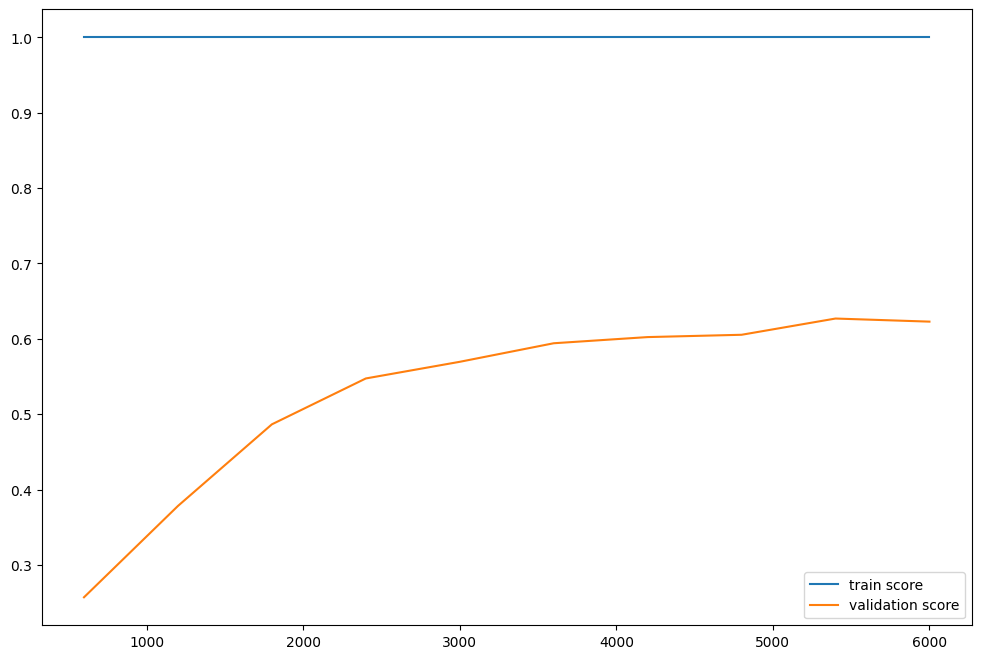

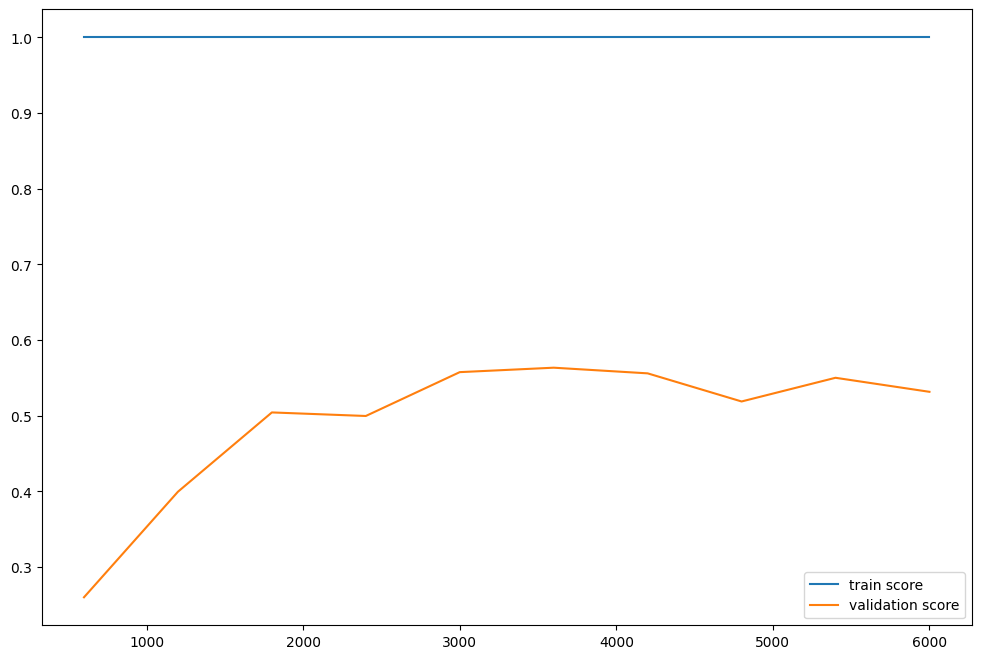

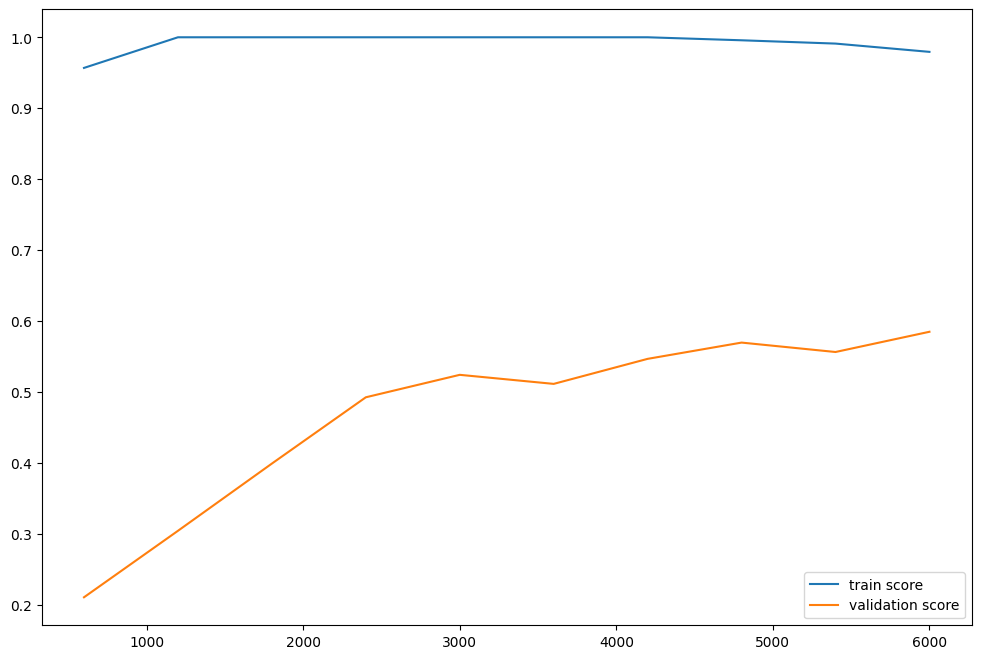

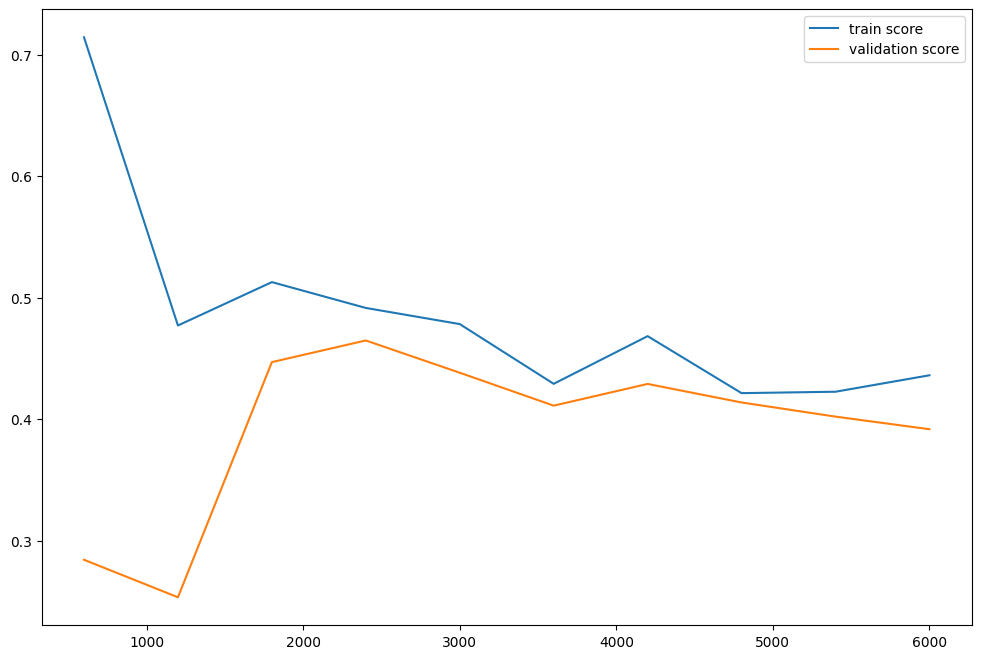

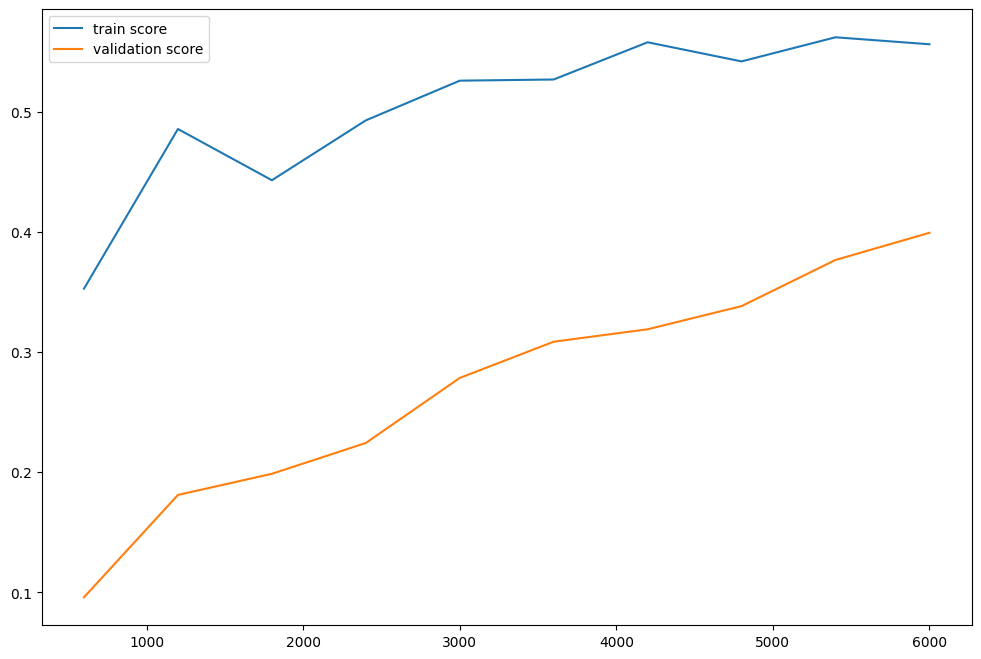

In [99]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

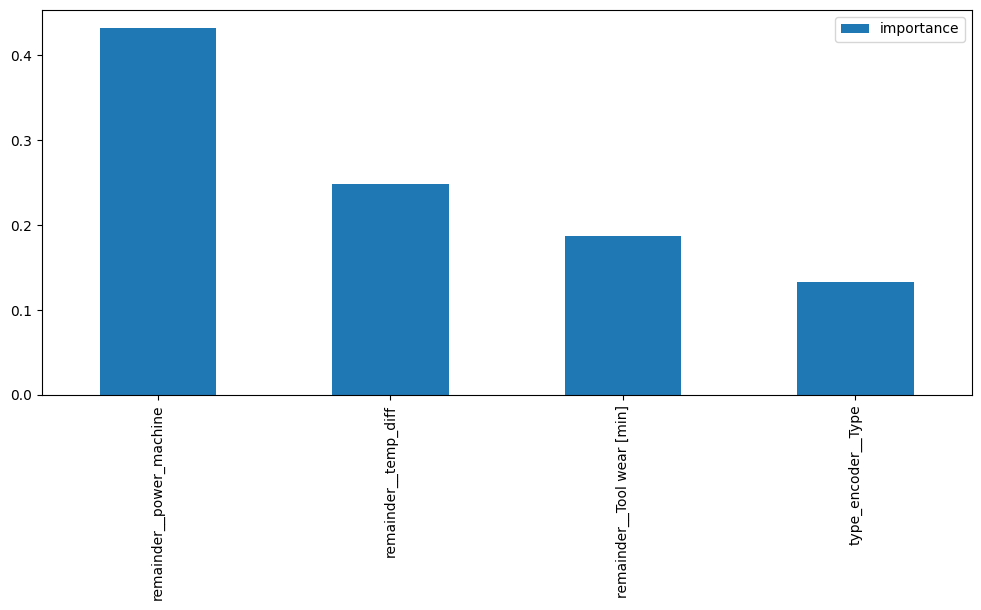

In [100]:
get_feature_importances(xgb_pipe, "preprocessor", "xgb")

Optimisation